In [1]:
import argparse
from datetime import datetime
import os
from pathlib import Path
import cv2
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from natsort import natsorted
import numpy as np
from pydantic import BaseModel
import uvicorn
from PIL import Image
from skimage import measure, color
from Resnet.my_resnet import ResnetModel
import torch
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from skimage import measure, filters, io, color

In [2]:
class DefectDetection:
    def __init__(self):
        self.model = ResnetModel()
        pass

    def __get_blocks_outputs__(self, image):
        input_tensor = self.model.preprocess.preprocess(image)

        output_block1 = self.model.block1(input_tensor)
        output_block2 = self.model.block2_out(output_block1)
        output_block3 = self.model.block3_out(output_block2)

        return output_block1, output_block2, output_block3


    def __get_result_and_concat__(self, image, concat_blocks = [1,2,3]):
        output_block1, output_block2, output_block3 = self.__get_blocks_outputs__(image=image)
        concat_array = [output_block1]

        if 1 in concat_blocks:
            concat_array.append(output_block1)
        if 2 in concat_blocks:
            concat_array.append(output_block2)
        if 3 in concat_blocks:
            concat_array.append(output_block3)

        concatenated_output = torch.cat(concat_array, dim=1)

        return output_block1, output_block2, output_block3, concatenated_output
    

    def detect(self, image_real, image_ideal, concat_blocks=[1,2,3]):
        output1_block1, output1_block2, output1_block3, concatenated_output_real = self.__get_result_and_concat__(image_real, concat_blocks=concat_blocks)
        image_concatenated1 = self.model.tensor_to_image(concatenated_output_real)

        output2_block1, output2_block2, output2_block3, concatenated_output_ideal = self.__get_result_and_concat__(image_ideal, concat_blocks=concat_blocks)
        image_concatenated2 = self.model.tensor_to_image(concatenated_output_ideal)

        diff = (concatenated_output_ideal - concatenated_output_real)
        # diff[diff < 0] = 0
        distance = torch.sqrt(torch.sum(diff ** 2, dim=1))

        # Convert distance array into numpy array
        distance_np = distance[0].detach().cpu().numpy()  # Remove batch dimension and convert to NumPy
        distance_np = distance_np - distance_np.min()

        distance_np_image = ((distance_np / distance_np.max()) * 255).astype(np.uint8)

        defect_mask = zoom(distance_np_image, (image_real.height / distance_np.shape[0], 
                                     image_real.width / distance_np.shape[1]), order=1)
        
        return defect_mask, distance_np_image
    
defectDetection = DefectDetection()

d:\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
image_real_path = "K:\Projects\GCode_Renderer\Images\Set2\In\img_2024-11-27T07-12-13.432Z_lp39.jpg"
image_ref_path = "K:\Projects\GCode_Renderer\Images\Set2\Ref\img_2024-11-26T23-00-29.092Z_lp39.jpg"
image_mask_path = "K:\Projects\GCode_Renderer\Images\Set2\Msk\msk_Z_lp39.png"
concat_blocks=[3]
defect_score_th=70
defect_area_th=128
defect_color = (255, 0, 0)

In [4]:
def show_img(img):
    cv2.imshow("Show Image", img)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

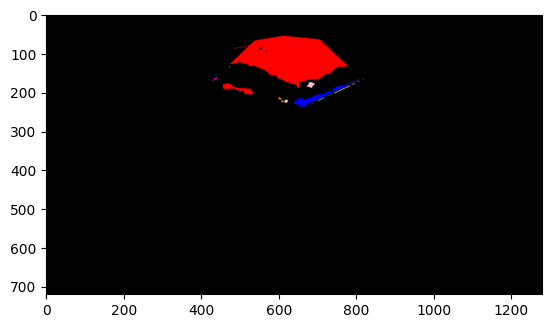

In [5]:
image_real= Image.open(image_real_path)
image_real = image_real.convert("RGB")
image_ref= Image.open(image_ref_path)
image_ref = image_ref.convert("RGB")
image_mask = Image.open(image_mask_path).convert("L")

binary_mask = np.array(image_mask) > 128
binary_mask = (binary_mask * 255).astype(np.uint8)

defect_mask, distance_np_image = defectDetection.detect(image_real, image_ref,concat_blocks=concat_blocks)
defect_mask_crop = cv2.bitwise_and(defect_mask,defect_mask,mask=binary_mask)
defect_mask_crop[defect_mask_crop < defect_score_th] = 0

threshold_value = filters.threshold_otsu(defect_mask_crop)  # Otsu's method for automatic thresholding
binary_image = defect_mask_crop > threshold_value

labeled_image = measure.label(binary_image, connectivity=2)
stats = measure.regionprops(labeled_image)

labeled_image_color = color.label2rgb(labeled_image, bg_label=0, kind='overlay')
plt.imshow(labeled_image_color)

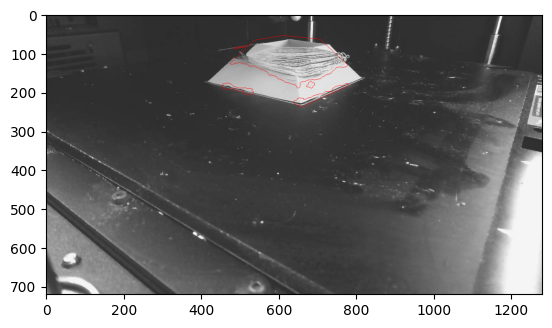

In [6]:
image_real_np = cv2.cvtColor(np.array(image_real), cv2.COLOR_RGB2GRAY)
cv2_image = cv2.cvtColor(image_real_np, cv2.COLOR_RGB2BGR)
has_detect = False
kernel = np.ones((3, 3), np.uint8)

for region in stats:  
    if region.area >= defect_area_th:
        has_detect = True
        mask = np.uint8(labeled_image == region.label)  # labels should be a 2D array with labels for each pixel

        dilated_image = cv2.dilate(mask, kernel, iterations=1)
        contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw all contours found (usually one per region)
        cv2.drawContours(cv2_image, contours, -1, defect_color, 1)

plt.imshow(cv2_image)